## The topic of this lecture:
1. how to use available dataset in PyTorch
2. how to use Feedforward Neural Network to do image classification

### Step 1: Loading MNIST Train Dataset

In [14]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# MNIST dataset
# https://en.wikipedia.org/wiki/MNIST_database

# download and save training data and testing data
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [15]:
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [16]:
print(test_dataset)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


torch.Size([1, 28, 28])
4


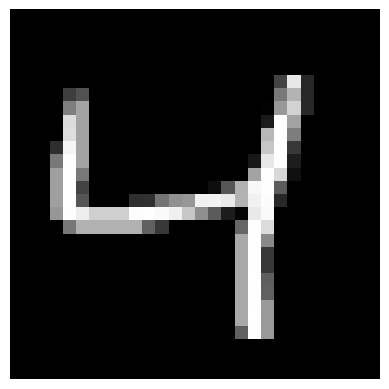

In [17]:
import matplotlib.pyplot as plt

img, label = train_dataset[2]
print(img.shape)
print(label)

plt.figure()
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")

### Step 2: Make Dataset Iterable

#### Batch sizes and iterations

Because we have 60000 training samples (images), we need to split them up to small groups (batches) and pass these batches of samples to our feedforward neural network subsesquently.

There are a few reasons why we split them into batches. Passing your whole dataset as a single batch would:

(1) require a lot of RAM/VRAM on your CPU/GPU and this might result in Out-of-Memory (OOM) errors.

(2) cause unstable training if you just use all the errors accumulated in 60,000 images to update the model rather than gradually update the model. In layman terms, imagine you accumulated errors for a student taking an exam with 60,000 questions and punish the student all at the same time. It is much harder for the student to learn compared to letting the student learn it made mistakes and did well in smaller batches of questions like mini-tests!

If we have 60,000 images and we want a batch size of 100, then we would have 600 iterations where each iteration involves passing 600 images to the model and getting their respective predictions.

#### Epoch

An epoch means that you have successfully passed the whole training set, 60,000 images, to the model. Continuing our example above, an epoch consists of 600 iterations.

If we want to go through the whole dataset 5 times (5 epochs) for the model to learn, then we need 3000 iterations (600 x 5).



In [18]:
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

10


### Step 3: Create Model Class


In [19]:
class FeedforwardNeuralNetModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 

        # Non-linearity
        self.sigmoid = nn.Sigmoid()

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        
        # Linear function  # LINEAR
        out = self.fc1(x)

        # Non-linearity  # NON-LINEAR
        out = self.sigmoid(out)

        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        
        return out

### Step 4: Instantiate Model Class

In [20]:
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

### Step 5: Instantiate Loss Class

#### Cross entropy
The cross entropy measures the performance of a classification model whose output is a probability value between 0 and 1. For two probability distributions $p=(p_1,p_2,\cdots,p_n)$ and $q=(q_1,q_2,\cdots,q_n)$ is defined as:
$$l(p,q) = - \sum_{i=1}^n q_i \log p_i$$

In [21]:
import numpy as np

q = np.array([0, 1, 0])             # True probability (from data)
p = np.array([0.228, 0.619, 0.153]) # Predicted probability (from the output of neural network)

print(-np.sum(q * np.log(p)))

0.47965000629754095


In [22]:
# perfect prediction
p = np.array([0.001, 0.998, 0.001])
print(-np.sum(q * np.log(p)))

0.0020020026706730793


In [23]:
# bad prediction
p = np.array([0.001, 0.001, 0.998])
print(-np.sum(q * np.log(p)))

6.907755278982137


#### Softmax function
Softmax function: $\sigma: \mathbb{R}^n \rightarrow (0,1)^n$ is defined:
$$
\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}},
$$
for $i=1,2,\cdots,n$ and $z=(z_1,z_2,\cdots,z_n)\in\mathbb{R}^n$.

In simple words, it applies the standard exponential function to each element $z_{i}$ of the input vector and normalizes these values by dividing by the sum of all these exponentials. This normalization ensures that the sum of the components of the output vector is 1.

In [24]:
m = nn.Softmax(dim=0)
input = torch.tensor([2.,3.])
print(input)

output = m(input)
print(output)

tensor([2., 3.])
tensor([0.2689, 0.7311])


In [25]:
# https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = nn.CrossEntropyLoss()

### Step 6: Instantiate Optimizer Class

In [26]:
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

### Step 7: Training

In [27]:
iter = 0
for epoch in range(num_epochs):
    
    for i, (images, labels) in enumerate(train_loader):
        
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28*28).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            
            # Calculate Accuracy         
            correct = 0
            total = 0
            
            # Iterate through test dataset
            for images, labels in test_loader:
                
                # Load images with gradient accumulation capabilities
                images = images.view(-1, 28*28).requires_grad_()

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}%'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6232898831367493. Accuracy: 85.48999786376953%
Iteration: 1000. Loss: 0.36981120705604553. Accuracy: 89.23999786376953%
Iteration: 1500. Loss: 0.44988223910331726. Accuracy: 90.56999969482422%
Iteration: 2000. Loss: 0.29529625177383423. Accuracy: 91.13999938964844%
Iteration: 2500. Loss: 0.3359542191028595. Accuracy: 91.58999633789062%
Iteration: 3000. Loss: 0.16718728840351105. Accuracy: 92.05000305175781%
Iteration: 3500. Loss: 0.22497308254241943. Accuracy: 92.33999633789062%
Iteration: 4000. Loss: 0.319786012172699. Accuracy: 92.58999633789062%
Iteration: 4500. Loss: 0.1389559656381607. Accuracy: 92.80000305175781%
Iteration: 5000. Loss: 0.13239392638206482. Accuracy: 93.0999984741211%
Iteration: 5500. Loss: 0.1964728981256485. Accuracy: 93.27999877929688%
Iteration: 6000. Loss: 0.18414334952831268. Accuracy: 93.48999786376953%
